## Reproducing Paper **Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks** : Benchmarking Results

This notebook replicates experiments from the paper [_Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks_](https://whitepaper.zama.ai/), published in 2021. 
It provides an in-depth analysis of the deep neural network architectures NN-20 and NN-50, along with their training processes using floating point precision and their [quantization](https://docs.zama.ai/concrete-ml/explanations/quantization) using the Quantization Aware Training (QAT) and Post Training Quantization (PTQ) methods. 

We compare the original paper's findings with the results from the latest version of [Concrete ML](https://pypi.org/project/concrete-ml/). This comparison highlights the significant advancements made by Concrete ML, particularly in execution speed while preserving model accuracy.

In [1]:
import csv
import os
import random
import time
import warnings
from glob import glob
from typing import Callable, List

import brevitas
import brevitas.nn as qnn
import numpy as np
import pandas as pd
import torch
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from utils_experiments import MEAN, STD, mapping_keys, plot_dataset, torch_inference, train

from concrete.ml.torch.compile import compile_brevitas_qat_model, compile_torch_model

warnings.filterwarnings("ignore", category=UserWarning)

## Architecture

All networks begin with a convolutional layer configured with `in_channel=1, out_channels=1, kernel_size=3, stride=1, padding_mode='replicate'`. 

This is followed by 20 linear layers of 92 neurones with ReLU activation for NN-20, and 50 layers for NN-50.

In [2]:
DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input size, 28x28 pixels, a standard size for MNIST images
INPUT_IMG_SIZE = 28

# Batch size
BATCH_SIZE = 64

# Seed to ensure reproducibility
SEED = 42

In [3]:
FEATURES_MAPS = [
    # The Bravitas.QuantIdentiy layer, only used in the quant NN, aims to quantize the input.
    # ("I",),
    # Convolution layer, with:
    # in_channel=1, out_channels=1, kernel_size=3, stride=1, padding_mode='replicate'
    ("C", 1, 1, 3, 1, "replicate"),
]


# The article presents 3 neural network depths. In this notebook, we focus NN-20 and NN-50
# architectures. The parameter `nb_layers`: controls the depth of the NN.
def LINEAR_LAYERS(nb_layers: int, output_size: int):
    return (  # noqa: W503
        [
            ("R",),
            ("L", INPUT_IMG_SIZE * INPUT_IMG_SIZE, 92),
            ("B", 92),
        ]  # noqa: W503
        + [  # noqa: W503
            ("R",),
            ("L", 92, 92),
            ("B", 92),
        ]
        * (nb_layers - 2)  # noqa: W503
        + [("L", 92, output_size)]  # noqa: W503
    )

### FP32 MNIST Neural Nerwork 

In [4]:
class Fp32MNIST(torch.nn.Module):
    """MNIST Torch model."""

    def __init__(self, nb_layers: int, output_size: int = 10):
        super(Fp32MNIST, self).__init__()
        """MNIST Torch model.

        Args:
            nb_layers (int): Number of layers.
            output_size (int): Number of classes.
        """
        self.nb_layers = nb_layers
        self.output_size = output_size

        def make_layers(t):
            if t[0] == "C":
                # Workaround: stride=1, padding_mode='replicate' is replaced by
                # transforms.Pad(1, padding_mode="edge")
                return torch.nn.Conv2d(
                    in_channels=t[1],
                    out_channels=t[2],
                    kernel_size=t[3],
                )
            if t[0] == "L":
                return torch.nn.Linear(in_features=t[1], out_features=t[2])
            if t[0] == "R":
                return torch.nn.ReLU()
            if t[0]:
                return torch.nn.BatchNorm1d(t[1])

            raise NameError(f"'{t}' not defined")

        # QuantIdentity layers are ignored in the floationg point architecture.
        self.features_maps = torch.nn.Sequential(
            *[make_layers(t) for t in FEATURES_MAPS if t[0] != "I"]
        )
        self.linears = torch.nn.Sequential(
            *[
                make_layers(t)
                for t in LINEAR_LAYERS(self.nb_layers, self.output_size)
                if t[0] != "I"
            ]
        )

    def forward(self, x):
        x = self.features_maps(x)
        x = torch.nn.Flatten()(x)
        x = self.linears(x)
        return x

### Quantized MNIST Neural Network

In [5]:
class QuantMNIST(torch.nn.Module):
    """Quantized MNIST network with Brevitas."""

    def __init__(
        self,
        n_bits: int,
        nb_layers: int,
        output_size: int = 10,
        act_quant: brevitas.quant = brevitas.quant.Int8ActPerTensorFloat,
        weight_quant: brevitas.quant = brevitas.quant.Int8WeightPerTensorFloat,
    ):
        """A quantized network with Brevitas.

        Args:
            n_bits (int): Precision bit of quantization.
            nb_layers (int): Number of layers.
            output_size (int): Number of classes
            act_quant (brevitas.quant): Quantization protocol of activations.
            weight_quant (brevitas.quant): Quantization protocol of the weights.
        """
        super(QuantMNIST, self).__init__()

        self.n_bits = n_bits
        self.nb_layers = nb_layers
        self.output_size = output_size

        def tuple2quantlayer(t):
            if t[0] == "R":
                return qnn.QuantReLU(
                    return_quant_tensor=True, bit_width=n_bits, act_quant=act_quant
                )
            if t[0] == "C":
                # Workaround: stride=1, padding_mode='replicate' is replaced by
                # transforms.Pad(1, padding_mode="edge")
                return qnn.QuantConv2d(
                    t[1],
                    t[2],
                    kernel_size=t[3],
                    weight_bit_width=2,
                    weight_quant=weight_quant,
                    return_quant_tensor=True,
                )
            if t[0] == "L":
                return qnn.QuantLinear(
                    in_features=t[1],
                    out_features=t[2],
                    weight_bit_width=n_bits,
                    weight_quant=weight_quant,
                    bias=True,
                    return_quant_tensor=True,
                )
            if t[0] == "I":
                identity_quant = t[1] if len(t) == 2 else n_bits
                return qnn.QuantIdentity(
                    bit_width=identity_quant, act_quant=act_quant, return_quant_tensor=True
                )
            if t[0] == "B":
                return torch.nn.BatchNorm1d(t[1])

        self.features_maps = torch.nn.Sequential(
            *[tuple2quantlayer(t) for t in FEATURES_MAPS if t[0]]
        )

        # self.identity1 and self.identity2 are used to encapsulate the `torch.flatten`.
        self.identity1 = qnn.QuantIdentity(
            bit_width=n_bits, act_quant=act_quant, return_quant_tensor=True
        )
        self.identity2 = qnn.QuantIdentity(
            bit_width=n_bits, act_quant=act_quant, return_quant_tensor=True
        )

        # QuantIdentity layers are taken into account
        self.linears = torch.nn.Sequential(
            *[tuple2quantlayer(t) for t in LINEAR_LAYERS(self.nb_layers, self.output_size)]
        )

    def forward(self, x):
        x = self.features_maps(x)
        x = self.identity1(x)
        x = torch.flatten(x, 1)
        x = self.identity2(x)
        x = self.linears(x)
        return x.value

In [6]:
def run_benchmark(
    model: Callable,
    compile_function: Callable,
    compile_type: str,
    data_calibration,
    data_loader,
    n_bits: int,
):
    nb_layers = model.nb_layers

    history = []
    filename = f"./benchmark/history_{nb_layers=}.csv"

    headers = [
        "compile_type",
        "number_of_layers",
        "QAT/PTQ_n_bits",
        "threshold_n_bits",
        "threshold_method",
        "max_bits",
        "mean_FP32_accuracy",
        "mean_disable_accuracy",
        "mean_simulate_accuracy",
        "FHE_timing",
        "INPUT_COMPRESSION",
    ]

    thresholds = [
        {"n_bits": 5, "method": "APPROXIMATE"},
        {"n_bits": 5, "method": "EXACT"},
        {"n_bits": 6, "method": "APPROXIMATE"},
        {"n_bits": 6, "method": "EXACT"},
        {"n_bits": 7, "method": "APPROXIMATE"},
        {"n_bits": 7, "method": "EXACT"},
    ]

    if not os.path.isfile(filename):
        with open(filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(headers)

    with open(filename, "a", newline="") as file:
        writer = csv.writer(file)

        for j, threshold in enumerate(thresholds):

            fhe_timing = -1
            history_fp32_predictions = []
            history_disable_predictions = []
            history_simulat_predictions = []

            try:
                q_module = compile_function(
                    model.to(DEVICE),
                    torch_inputset=data_calibration,
                    n_bits=n_bits if compile_type == "PTQ" else None,
                    rounding_threshold_bits=threshold,
                )

                max_bits = q_module.fhe_circuit.graph.maximum_integer_bit_width()
                print(f"{j=}: {max_bits=} after compilation")

                for i, (data, labels) in enumerate(data_loader):

                    fp32_predictions = model(data).cpu().detach()
                    history_fp32_predictions.extend(fp32_predictions.argmax(1) == labels)

                    data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()

                    disable_predictions = q_module.forward(data, fhe="disable")
                    history_disable_predictions.extend(disable_predictions.argmax(1) == labels)

                    simulat_predictions = q_module.forward(data, fhe="simulate")
                    history_simulat_predictions.extend(simulat_predictions.argmax(1) == labels)

                    if i == 0:
                        start_time = time.time()
                        q_module.forward(data[0, None], fhe="execute")
                        fhe_timing = (time.time() - start_time) / 60.0

                row = [
                    compile_type,
                    nb_layers,
                    n_bits,
                    threshold["n_bits"],
                    threshold["method"],
                    max_bits,
                    np.mean(history_fp32_predictions),
                    np.mean(history_disable_predictions),
                    np.mean(history_simulat_predictions),
                    fhe_timing,
                    os.environ.get("USE_INPUT_COMPRESSION", "1"),
                ]

            except BaseException:
                row = [
                    compile_type,
                    nb_layers,
                    n_bits,
                    threshold["n_bits"],
                    threshold["method"],
                    -1,
                    -1,
                    -1,
                    -1,
                    -1,
                    -1,
                ]

            writer.writerow(row)
            print(f"{j=}: {row=}")
            history.append(dict(zip(headers, row)))

    return history


def ptq_benchmark(
    nb_layers: int,
    data_calibration: datasets,
    data_loader: DataLoader,
    n_bits: List = [5, 6, 7],
    model_dir: str = "./checkpoints/MNIST/",
):
    # Test all fp32 pre-trained models, saved in the following path
    state_dict_paths = glob(f"{model_dir}/NLP_{nb_layers}/fp32/*fp32_state_dict.pt")
    assert len(state_dict_paths) > 0, f"There are no fp32 pre-trained models inside {model_dir}."

    for state_dict_path in state_dict_paths:
        checkpoint = torch.load(state_dict_path, map_location=DEVICE)
        fp32_model = Fp32MNIST(nb_layers=nb_layers).to(DEVICE)
        fp32_model.load_state_dict(checkpoint)
        print(f"FP32 model loaded in: '{state_dict_path}'")

        # In PTQ, we have to specify the quantization bit precision
        for bit in tqdm(n_bits):
            run_benchmark(
                fp32_model,
                compile_function=compile_torch_model,
                compile_type="PTQ",
                data_calibration=data_calibration,
                data_loader=data_loader,
                n_bits=bit,
            )


def qat_benchmark(
    nb_layers: int,
    data_calibration: datasets,
    data_loader: DataLoader,
    model_dir: str = "./checkpoints/MNIST",
):
    # Test all quantized pre-trained models, saved in the following path
    state_dict_paths = glob(f"{model_dir}/NLP_{nb_layers}/quant_*/*_state_dict.pt")
    assert len(state_dict_paths) > 0, f"There are no pretrained models in {model_dir}"

    for state_dict_path in state_dict_paths:
        checkpoint = torch.load(state_dict_path, map_location=DEVICE)
        bit = int(state_dict_path.split("/")[-2].split("=")[-1])
        quant_model = QuantMNIST(n_bits=bit, nb_layers=nb_layers).to(DEVICE)
        quant_model.load_state_dict(checkpoint)
        print(f"Quantized model loaded in: '{state_dict_path}'")

        run_benchmark(
            quant_model,
            compile_function=compile_brevitas_qat_model,
            compile_type="QAT",
            data_calibration=data_calibration,
            data_loader=data_loader,
            n_bits=bit,
        )

In [55]:
PAPER_NOTES_20 = [20, 115.52, 0.97]
PAPER_NOTES_50 = [50, 233.55, 0.80]


def best_configuration(machine_type, paper_notes):

    df = pd.read_csv(f"benchmark/history_nb_layers={paper_notes[0]}.csv")
    # assert (df["mean_disable_accuracy"] - df["mean_simulate_accuracy"]).mean() <= 0.0005

    # Filter data for specific machine
    df = df[df["machine"] == machine_type]

    # Filter best configuration for specific machine
    df = df[
        (
            (df["mean_FP32_accuracy"] <= df["mean_disable_accuracy"])
            | ((df["mean_FP32_accuracy"] - df["mean_disable_accuracy"]) <= 0.01)
        )  # nbqa: W503
        & (df["mean_FP32_accuracy"] >= paper_notes[2])  # nbqa: W503
    ]

    best_df = []
    for compile_type in ["PTQ", "QAT"]:

        df_filtred = df[df["compile_type"] == compile_type]
        df_filtred = df_filtred.sort_values(
            by=["FHE_timing", "mean_simulate_accuracy"], ascending=[True, False]
        )

        # Best configuration
        best_conf = df_filtred.iloc[0].to_dict()
        print(f"Best configuration with {compile_type}:\n{best_conf}")

        print(
            f"For machie: {machine_type} - compile_ method : {compile_type}\n"
            f"Compared to the data from the paper, which recorded for NN-{paper_notes[0]} and "
            f"inference time of {paper_notes[1]} seconds.\nWe observe a significant gain in this new "
            f"Concrete ML version. The inference time has been reduced to "
            f"{best_conf['FHE_timing']:.2f} seconds.\nThis represents a reduction factor of "
            f"{round(paper_notes[1] / best_conf['FHE_timing'])}.\n"
        )

        best_df.append(df_filtred.head(8))

    return pd.concat([best_df[0], best_df[1]])

## Load MNIST data-set

At the time of writing this notebook, `padding=1` is not yet supported by Concrete ML ; as a workaround, padding is added during the data loading transformation process.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


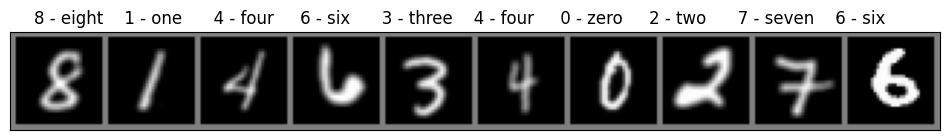

In [8]:
g = torch.Generator()
g.manual_seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

train_transform = transforms.Compose(
    [  # Workaround: stride=1, padding_mode='replicate' is replaced by
        # transforms.Pad(1, padding_mode="edge")
        transforms.Pad(1, padding_mode="edge"),
        transforms.ToTensor(),
        transforms.Normalize((MEAN,), (STD,)),
        transforms.GaussianBlur(kernel_size=(3, 3)),
    ]
)
test_transform = transforms.Compose(
    [  # Workaround: stride=1, padding_mode='replicate' is replaced by
        # transforms.Pad(1, padding_mode="edge")
        transforms.Pad(1, padding_mode="edge"),
        transforms.ToTensor(),
        transforms.Normalize((MEAN,), (STD,)),
    ]
)

train_dataset = datasets.MNIST(download=True, root="./data", train=True, transform=train_transform)

test_dataset = datasets.MNIST(download=True, root="./data", train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    generator=g,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    generator=g,
)

plot_dataset(train_loader)

## FHE-Compatible

In the next sections of this notebook, we apply the same experimental protocol to both NN-20 and NN-50 models.

To make a custom neural network FHE-compatible, it's necessary to quantize both the network and its inputs.

Quantization is essentially the process of converting continuous data into integers. This is critical in the context of T-FHE. For custom neural Nntworks (NN), 2 widely methods are supported in concrete ML:

- Post-Training Quantization (PTQ): This method involves quantizing a pre-trained floating-point model directly, noted here `fp32_mnist`. While PTQ is straightforward and does not require re-training, it can sometimes compromise the model's performance due to the abrupt adjustment to lower precision. In Concrete Ml, the compilation of the custom NNs is performed through `compile_torch_model` function
- Quantization-Aware Training (QAT): Unlike PTQ, QAT integrates quantization into the training cycle, allowing the model to adapt to the quantization effects iteratively. This method often achieves better results but requires a specific framework, designed for neural network quantization. At Concrete ML, Brevitas framework is supported, and the compilation is performed through `compile_brevitas_qat_model` function*

In the compilation step, the compiler requires an exhaustive set of data, here noted `data_calibration` to evaluate the maximum integer bit-width within the graph.

In [9]:
data_calibration = next(iter(train_loader))[0]

data_calibration.shape

torch.Size([64, 1, 30, 30])

## Floating Point Precision: 20-Layer MNIST

Let's strart with the NN-20.

The model weights are saved in the file `checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt`.

To train the network, set the `train_model` flag to `True`.

In [10]:
nb_layers, train_model = 20, False

param = {
    "training": "fp32",
    "dir": f"./checkpoints/MNIST/NLP_{nb_layers}/",
    "epochs": 30,
    "lr": 0.01,
    "milestones": [15, 24],
    "gamma": 0.1,
}

fp32_mnist = Fp32MNIST(nb_layers=nb_layers).to(DEVICE)

if train_model:
    assert str(fp32_mnist.nb_layers) in param["dir"]
    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=DEVICE)

else:
    checkpoint = torch.load(f"{param['dir']}/fp32/MNIST_fp32_state_dict.pt", map_location=DEVICE)
    fp32_mnist.load_state_dict(checkpoint)

acc_train = torch_inference(fp32_mnist, train_loader, device=DEVICE)
acc_test = torch_inference(fp32_mnist, test_loader, device=DEVICE)

print(
    f"Floating point network: with {fp32_mnist.nb_layers}-NN MNIST:\n"
    f"{acc_train:.3%} for training set and {acc_test:.3%} for test set"
)

Floating point network: with 20-NN MNIST:
99.331% for training set and 98.137% for test set


## Quantization: 20-Layer MNIST

`QuantMNIST` is the quantized counterpart of the `fp32MNIST` model using [Brevitas]().

Quantization aware training can be slow, so a useful strategy is to initialize the quantized network with pre-trained fp32 weights and then fine-tune it. 

Typically, a few epochs are sufficient to achieve good results with this approach.

In [11]:
# Quantization with 4-bits
bits, nb_layers, finetune_model = 4, 20, False

param = {
    "training": f"quant_mnist_{bits=}",
    "dir": f"./checkpoints/MNIST/NLP_{nb_layers}/",
    "epochs": 5,  # A few epochs are enough to achieve good results
    "lr": 0.1,
    "milestones": [1, 3],
    "gamma": 0.1,
}

quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to(DEVICE)

# Affect the pre-trained  FP32 weights to the equivalent quantized network
quant_mnist = mapping_keys(checkpoint, quant_mnist, device=DEVICE)

# Assess the quantized model before fine-tuning
acc_train_before_ft = torch_inference(quant_mnist, train_loader, device=DEVICE)
acc_test_before_ft = torch_inference(quant_mnist, test_loader, device=DEVICE)
print(
    f"With {quant_mnist.n_bits}-bits and {quant_mnist.nb_layers}-layers:\n"
    f"Accuracy before fine-tuning: {acc_train_before_ft:.3%} "
    f"for the training set and {acc_test_before_ft:.3%} for the test set"
)

# Fine-tune the quantized model
if finetune_model:
    assert str(quant_mnist.nb_layers) in param["dir"]
    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=DEVICE)

# Load the pre-trained quantized model with 20-layers
else:
    path = f"{param['dir']}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
    quant_mnist.load_state_dict(torch.load(path, map_location=DEVICE))

# Assess the quantized model after fine-tuning
acc_train_after_ft = torch_inference(quant_mnist, train_loader, device=DEVICE)
acc_test_after_ft = torch_inference(quant_mnist, test_loader, device=DEVICE)

print(
    f"Accuracy after fine-tuning: {acc_train_after_ft:.3%} for the training "
    f"set and {acc_test_after_ft:.3%} for the test set\n"
)

With 4-bits and 20-layers:
Accuracy before fine-tuning: 9.750% for the training set and 9.736% for the test set
Accuracy after fine-tuning: 97.322% for the training set and 97.165% for the test set



In [12]:
# Quantization with 5-bits
bits, nb_layers = 5, 20

# Load the pre-trained quantized model with 20-layers
path = f"{param['dir']}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"

quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=DEVICE))

# Assess the quantized model after fine-tuning
acc_train_after_ft = torch_inference(quant_mnist, train_loader, device=DEVICE)
acc_test_after_ft = torch_inference(quant_mnist, test_loader, device=DEVICE)

print(
    f"Accuracy after fine-tuning: {acc_train_after_ft:.3%} for "
    f"the training set and {acc_test_after_ft:.3%} for the test set\n"
)

Accuracy after fine-tuning: 97.986% for the training set and 97.726% for the test set



### MNIST NN-20: Benchmark

In [13]:
# qat_benchmark(nb_layers=20, data_loader=test_loader, data_calibration=data_calibration)

In [14]:
# ptq_benchmark(nb_layers=20, data_loader=test_loader, data_calibration=data_calibration)

In [10]:
best_configuration(machine_type="PC", paper_notes=PAPER_NOTES_20)

Best configuration with PTQ:
{'compile_type': 'PTQ', 'number_of_layers': 20, 'QAT/PTQ_n_bits': 5, 'threshold_nbits': 6.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 15, 'mean_FP32_accuracy': 0.978165064102564, 'mean_disable_accuracy': 0.9729567307692308, 'mean_simulate_accuracy': 0.9724559294871796, 'FHE_timing': 1.8427709062894184, 'input_compression': 0, 'machine': 'PC'}
For machie: PC - compile_ method : PTQ
Compared to the data from the paper, which recorded for NN-20 and inference time of 115.52 seconds.
We observe a significant gain in this new Concrete ML version. The inference time has been reduced to 1.84 seconds.
This represents a reduction factor of 63.

Best configuration with QAT:
{'compile_type': 'QAT', 'number_of_layers': 20, 'QAT/PTQ_n_bits': 5, 'threshold_nbits': 6.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 16, 'mean_FP32_accuracy': 0.9729567307692308, 'mean_disable_accuracy': 0.971153846153846, 'mean_simulate_accuracy': 0.971153846153846, 'FHE_timing': 1.78

,compile_type,number_of_layers,QAT/PTQ_n_bits,threshold_nbits,threshold_method,max_bits,mean_FP32_accuracy,mean_disable_accuracy,mean_simulate_accuracy,FHE_timing,input_compression,machine
40,PTQ,20,5,6.0,APPROXIMATE,15,0.978165,0.972957,0.972456,1.842771,0,PC
70,PTQ,20,6,6.0,APPROXIMATE,17,0.976362,0.975361,0.945813,2.169491,1,PC
46,PTQ,20,6,6.0,APPROXIMATE,17,0.976362,0.975761,0.948618,2.184025,0,PC
22,QAT,20,5,6.0,APPROXIMATE,16,0.972957,0.971154,0.971154,1.784744,0,PC
58,QAT,20,5,6.0,APPROXIMATE,16,0.972155,0.969351,0.930689,2.295221,1,PC
23,QAT,20,5,6.0,EXACT,16,0.971254,0.970453,0.970453,3.121205,0,PC


In [12]:
best_configuration(machine_type="HP7C", paper_notes=PAPER_NOTES_20)

Best configuration with PTQ:
{'compile_type': 'PTQ', 'number_of_layers': 20, 'QAT/PTQ_n_bits': 6, 'threshold_nbits': 6.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 17, 'mean_FP32_accuracy': 0.9763621794871796, 'mean_disable_accuracy': 0.9752604166666666, 'mean_simulate_accuracy': 0.963241185897436, 'FHE_timing': 0.2431224187215169, 'input_compression': 0, 'machine': 'HP7C'}
For machie: HP7C - compile_ method : PTQ
Compared to the data from the paper, which recorded for NN-20 and inference time of 115.52 seconds.
We observe a significant gain in this new Concrete ML version. The inference time has been reduced to 0.24 seconds.
This represents a reduction factor of 475.

Best configuration with QAT:
{'compile_type': 'QAT', 'number_of_layers': 20, 'QAT/PTQ_n_bits': 5, 'threshold_nbits': 6.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 16, 'mean_FP32_accuracy': 0.9736578525641024, 'mean_disable_accuracy': 0.9697516025641024, 'mean_simulate_accuracy': 0.9700520833333334, 'FHE_timing

,compile_type,number_of_layers,QAT/PTQ_n_bits,threshold_nbits,threshold_method,max_bits,mean_FP32_accuracy,mean_disable_accuracy,mean_simulate_accuracy,FHE_timing,input_compression,machine
128,PTQ,20,6,6.0,APPROXIMATE,17,0.976362,0.975260,0.963241,0.243122,0,HP7C
94,PTQ,20,5,6.0,APPROXIMATE,15,0.976562,0.975160,0.972256,0.281484,0,HP7C
95,PTQ,20,5,6.0,EXACT,15,0.975761,0.973357,0.970954,0.376488,0,HP7C
125,QAT,20,5,6.0,APPROXIMATE,16,0.973658,0.969752,0.970052,0.318072,0,HP7C
121,QAT,20,5,6.0,APPROXIMATE,16,0.973658,0.969752,0.970052,0.319026,0,HP7C
88,QAT,20,5,6.0,APPROXIMATE,16,0.974659,0.970753,0.971154,0.341152,0,HP7C


## Floating Point Precision: 50-Layer MNIST

Same protocol as the MNIST 20-layers.

The network is trained in floationg point precision, then quantized with the QAT method.

In [17]:
nb_layers = 50
param = {"dir": f"./checkpoints/MNIST/NLP_{nb_layers}/"}

In [18]:
checkpoint = torch.load(f"{param['dir']}/fp32/MNIST_fp32_state_dict.pt", map_location=DEVICE)

fp32_mnist = Fp32MNIST(nb_layers=nb_layers).to(DEVICE)
fp32_mnist.load_state_dict(checkpoint)

acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=DEVICE)
acc_after_ft_test = torch_inference(fp32_mnist, test_loader, device=DEVICE)

print(
    f"FP32 - with {fp32_mnist.nb_layers}-NN: {acc_train:.3%} for "
    f"training set and {acc_test:.3%} for test set"
)

FP32 - with 50-NN: 99.331% for training set and 98.137% for test set


## Quantization: 50-Layer MNIST

In [19]:
# quantization with 4-bits
bits, nb_layers = 4, 50

# Load pre-trained quantized model
path = f"{param['dir']}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"

quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to(DEVICE)
quant_mnist.load_state_dict(torch.load(path, map_location=DEVICE))

# Assess the model after fine-tuning
acc_train_after_ft = torch_inference(quant_mnist, train_loader, device=DEVICE)
acc_test_after_ft = torch_inference(quant_mnist, test_loader, device=DEVICE)

print(
    f"Accuracy after fine-tuning: {acc_train_after_ft:.3%} for "
    f"the training set and {acc_test_after_ft:.3%} for the test set\n"
)

Accuracy after fine-tuning: 93.400% for the training set and 93.409% for the test set



### MNIST NN-50: Benchmark

In [20]:
# ptq_benchmark(nb_layers=50, data_loader=test_loader, data_calibration=data_calibration)

In [21]:
# qat_benchmark(nb_layers=50, data_loader=test_loader, data_calibration=data_calibration)

In [51]:
best_configuration(machine_type="PC", paper_notes=PAPER_NOTES_50)

Best configuration with PTQ:
{'compile_type': 'PTQ', 'number_of_layers': 50, 'QAT/PTQ_n_bits': 5, 'threshold_n_bits': 7.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 15, 'mean_FP32_accuracy': 0.9665464743589745, 'mean_disable_accuracy': 0.9579326923076924, 'mean_simulate_accuracy': 0.9549278846153846, 'FHE_timing': 11.522332433859509, 'input_compression': 0, 'machine': 'PC'}
For machie: PC - compile_ method : PTQ
Compared to the data from the paper, which recorded for NN-50 and inference time of 233.55 seconds.
We observe a significant gain in this new Concrete ML version. The inference time has been reduced to 11.52 seconds.
This represents a reduction factor of 20.

Best configuration with QAT:
{'compile_type': 'QAT', 'number_of_layers': 50, 'QAT/PTQ_n_bits': 4, 'threshold_n_bits': 5.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 14, 'mean_FP32_accuracy': 0.88671875, 'mean_disable_accuracy': 0.8990384615384616, 'mean_simulate_accuracy': 0.8973357371794872, 'FHE_timing': 1.6271

,compile_type,number_of_layers,QAT/PTQ_n_bits,threshold_n_bits,threshold_method,max_bits,mean_FP32_accuracy,mean_disable_accuracy,mean_simulate_accuracy,FHE_timing,input_compression,machine
13,PTQ,50,5,7.0,APPROXIMATE,15,0.966546,0.957933,0.954928,11.522332,0,PC
14,PTQ,50,5,7.0,EXACT,15,0.967147,0.965946,0.933093,14.316687,0,PC
40,QAT,50,4,5.0,APPROXIMATE,14,0.886719,0.899038,0.897336,1.627101,1,PC
38,QAT,50,4,5.0,APPROXIMATE,14,0.889924,0.898838,0.897135,1.701109,0,PC
37,QAT,50,4,5.0,APPROXIMATE,14,0.882913,0.898838,0.897135,1.925014,0,PC
15,QAT,50,4,5.0,EXACT,14,0.886719,0.899038,0.898938,3.022286,0,PC
42,QAT,50,4,6.0,APPROXIMATE,14,0.889323,0.888522,0.889523,3.779341,1,PC
23,QAT,50,4,6.0,EXACT,14,0.890425,0.935397,0.935397,4.680738,0,PC
17,QAT,50,4,6.0,EXACT,14,0.889323,0.888522,0.888522,4.700674,0,PC
43,QAT,50,4,6.0,EXACT,14,0.882913,0.920072,0.920072,4.812003,1,PC


In [56]:
best_configuration(machine_type="HP7C", paper_notes=PAPER_NOTES_50)

Best configuration with PTQ:
{'compile_type': 'PTQ', 'number_of_layers': 50, 'QAT/PTQ_n_bits': 5, 'threshold_n_bits': 6.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 15, 'mean_FP32_accuracy': 0.9678485576923076, 'mean_disable_accuracy': 0.9588341346153846, 'mean_simulate_accuracy': 0.951622596153846, 'FHE_timing': 0.8221531271934509, 'input_compression': 0, 'machine': 'HP7C'}
For machie: HP7C - compile_ method : PTQ
Compared to the data from the paper, which recorded for NN-50 and inference time of 233.55 seconds.
We observe a significant gain in this new Concrete ML version. The inference time has been reduced to 0.82 seconds.
This represents a reduction factor of 284.

Best configuration with QAT:
{'compile_type': 'QAT', 'number_of_layers': 50, 'QAT/PTQ_n_bits': 4, 'threshold_n_bits': 5.0, 'threshold_method': 'APPROXIMATE', 'max_bits': 14, 'mean_FP32_accuracy': 0.8862179487179487, 'mean_disable_accuracy': 0.879707532051282, 'mean_simulate_accuracy': 0.8645833333333334, 'FHE_timin

,compile_type,number_of_layers,QAT/PTQ_n_bits,threshold_n_bits,threshold_method,max_bits,mean_FP32_accuracy,mean_disable_accuracy,mean_simulate_accuracy,FHE_timing,input_compression,machine
58,PTQ,50,5,6.0,APPROXIMATE,15,0.967849,0.958834,0.951623,0.822153,0,HP7C
79,PTQ,50,6,6.0,APPROXIMATE,17,0.967849,0.958233,0.962540,1.149665,0,HP7C
80,PTQ,50,6,6.0,EXACT,17,0.964243,0.960136,0.947616,1.326429,0,HP7C
84,PTQ,50,7,6.0,APPROXIMATE,19,0.965144,0.958433,0.956731,2.332958,0,HP7C
179,PTQ,50,7,6.0,APPROXIMATE,19,0.969852,0.963842,0.942708,2.352652,0,HP7C
81,PTQ,50,6,7.0,APPROXIMATE,17,0.967849,0.962039,0.942508,2.381191,0,HP7C
82,PTQ,50,6,7.0,EXACT,17,0.966947,0.964443,0.953626,2.689226,0,HP7C
176,PTQ,50,7,6.0,APPROXIMATE,19,0.966947,0.958934,0.957432,8.223564,0,HP7C
146,QAT,50,4,5.0,APPROXIMATE,14,0.886218,0.879708,0.864583,0.263709,0,HP7C
125,QAT,50,4,5.0,APPROXIMATE,15,0.889623,0.882913,0.882312,0.302718,0,HP7C
